In [1]:
import os
import sys
from pathlib import Path

import folium
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask

In [2]:
# Add the parent directory to the path to make imports work

module_path = os.path.abspath(os.path.join(".."))

if module_path not in sys.path:
    sys.path.append(module_path)

from src import utils

In [3]:
landsat_id = "LC08_L1TP_142051_20180312_20200901_02_T1"  # Copy from file name

# Selected area from https://geojson.io/
geojson_file = "chennai.geojson"


## Steps

1. Create a folder "data" in parent directory and then, create "landsat" folder inside it.
2. Then create a folder inside /data/landsat folder "/data/landsat/source".
3. Again create a folder inside /data folder "/data/landsat/output".
4. Now, again create a folder inside /data/landsat/source folder with landsat_id "/data/landsat/source/LC08_L1TP_142051_20180312_20200901_02_T1"
5. Download landsat data from website and extract it into "/data/landsat/source/LC08_L1TP_142051_20180312_20200901_02_T1" folder .


In [4]:
from src import utils
from src.utils import clip_to_geojson


# Main directory where all the data are stored.
dir_data=Path("../data")

# base directory for Landsat data files
dir_data_landsat = Path(dir_data,"landsat")

# The source directory contains the original Landsat files
# Its name is the original Landsat ID (set above)
dir_source =Path(dir_data_landsat,"source",landsat_id)

# The output directory will contain the preprocessed files
dir_output = Path(dir_data_landsat,"output",landsat_id)

# Create the directories if they do not exist
for directory in [dir_data_landsat,dir_output]:
    Path(directory).mkdir(parents=True, exist_ok=True)

# file path
geojson_path = Path(dir_data, "geojson",geojson_file)
mtl_path = Path(dir_source, landsat_id + "_MTL.txt")

# Bands
band_4_path = Path(dir_source, landsat_id + "_B4.TIF")  # Red 
band_5_path = Path(dir_source, landsat_id + "_B5.TIF")  # Near Infrared
band_10_path = Path(dir_source, landsat_id + "_B10.TIF") # Thermal Infrared


for band_path in [band_4_path, band_5_path, band_10_path]:
    if not band_path.exists():
        raise FileNotFoundError(f"File not found: {band_path}")

# Paths clipped to GeoJson
band_4_clipped_path = utils.clip_to_geojson(band_4_path, geojson_path, dir_output)
band_5_clipped_path = utils.clip_to_geojson(band_5_path, geojson_path, dir_output)
band_10_clipped_path = utils.clip_to_geojson(band_10_path, geojson_path, dir_output)

# Output file paths
file_lst = Path(dir_output, "temperature_lst.tif")
file_lst_repr = Path(dir_output, "temperature_lst_reprojected.tif")
file_lst_repr_colored = Path(dir_output, "temperature_lst_reprojected_colored.tif")

file_ndvi = Path(dir_output, "ndvi.tif")
file_ndvi_repr = Path(dir_output, "ndvi_reprojected.tif")
file_ndvi_repr_colored = Path(dir_output, "ndvi_reprojected_colored.tif")

file_emissivity = Path(dir_output, "emissivity.tif")
file_emissivity_repr = Path(dir_output, "emissivity_reprojected.tif")
file_emissivity_repr_colored = Path(dir_output, "emissivity_reprojected_colored.tif")

FileNotFoundError: File not found: ..\data\landsat\source\LC08_L1TP_142051_20180312_20200901_02_T1\LC08_L1TP_142051_20180312_20200901_02_T1_B4.TIF

## Calculate Metrics
```py
def calc_ndvi(band_4_path: Path, band_5_path: Path, target_path: Path) -> np.ndarray:
    
    with rasterio.open(band_4_path) as src:
        band_4 = src.read(1)
    with rasterio.open(band_5_path) as src:
        band_5 = src.read(1)
        
        out_meta = src.meta.copy()
    
    mask = band_4 == 0
    ndvi_image_array = ndvi(band_5,band_4,mask=mask)
    
    out_meta.update(
        {
            "height": ndvi_image_array.shape[0],
            "width": ndvi_image_array.shape[1],
            "transform": src.transform,
            "dtype": ndvi_image_array.dtype,
        }
    )
    
    # Save NDVI as GeoTIFF
    with rasterio.open(target_path, "w", **out_meta) as dst:
        dst.write(ndvi_image_array, 1)
    print("Save NVDI to ", target_path)
    
    return ndvi_image_array
```


In [ ]:
ndvi = utils.calc_ndvi(band_4_clipped_path, band_5_clipped_path, file_ndvi)

Save NVDI to  ..\data\landsat\output\LC08_L1TP_142051_20180312_20200901_02_T1\ndvi.tif


# Show image


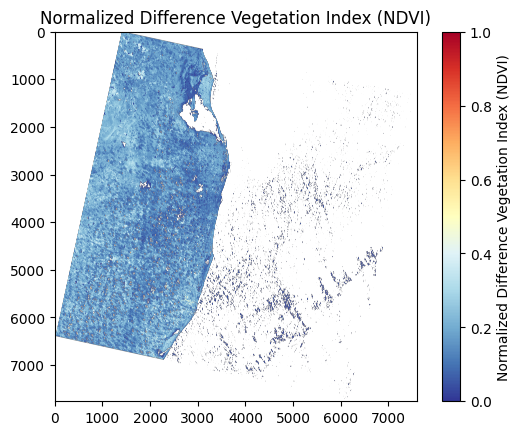

In [ ]:
plt.imshow(ndvi, cmap="RdYlBu_r")
plt.colorbar(label="Normalized Difference Vegetation Index (NDVI)")
plt.title("Normalized Difference Vegetation Index (NDVI)")
plt.show()

## Calculate LST

```py
def calc_lst(band_4_path: Path, band_5_path: Path, band_10_path: Path, target_path: Path) -> np.ndarray:
    
    with rasterio.open(band_4_path) as src:
        band_4 =  src.read(1)
    with rasterio.open(band_5_path) as src:
        band_5 =  src.read(1)
    with rasterio.open(band_10_path) as src:
        band_10 =  src.read(1)
        
        
        out_meta = src.meta.copy()
    
    # Compute Land Surface Temperature (LST)
    lst_image_array = single_window(band_10,band_4,band_5, unit="celsius")
    
    # For some reason, the values are in Kelvin, so we need to convert them to Celsius
    lst_image_array = lst_image_array - 273.15
    
    out_meta.update(
        {
            "height": lst_image_array.shape[0],
            "width": lst_image_array.shape[1],
            "transform": src.transform,
            "dtype": lst_image_array.dtype,
        }
    )
    
    # Save LST as GeoTIFF
    with rasterio.open(target_path, "w", **out_meta) as dst:
        dst.write(lst_image_array, 1)
    print("Saved Land Surface Temperature (LST) to", target_path)

    return lst_image_array
```

In [ ]:
lst = utils.calc_lst(
    band_4_clipped_path, band_5_clipped_path, band_10_clipped_path, file_lst
)

Saved Land Surface Temperature (LST) to ..\data\landsat\output\LC08_L1TP_142051_20180312_20200901_02_T1\temperature_lst.tif


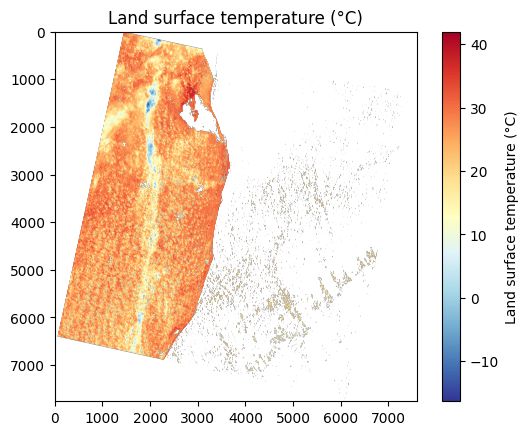

In [ ]:
# Show image
plt.imshow(lst, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")
plt.show()

## Calculate Emissivity

```py
def calc_emissivity(band_4_path: Path, band_5_path: Path, target_path: Path) -> np.ndarray:
    
    with rasterio.open(band_4_path) as src:
        band_4 = src.read(1)
    with rasterio.open(band_5_path) as src:
        band_5 = src.read(1)
        
        out_meta = src.meta.copy()
    
    mask = band_4 == 0
    
    ndvi_image_array = ndvi(band_5, band_4, mask=mask)

    emissivity_10_array, emissivity_11_array = emissivity(
        ndvi_image_array, emissivity_method="xiaolei", landsat_band_4=band_4
    )
    
    
    out_meta.update(
        {
            "height": emissivity_10_array.shape[0],
            "width": emissivity_10_array.shape[1],
            "transform": src.transform,
            "dtype": emissivity_10_array.dtype,
        }
    )
    
    # Save emissivity as GeoTIFF
    with rasterio.open(target_path, "w", **out_meta) as dst:
        dst.write(emissivity_10_array, 1)

    print("Saved Emissivity to", target_path)

    return emissivity_10_array
```

In [ ]:
emissivity = utils.calc_emissivity(
    band_4_clipped_path, band_5_clipped_path, file_emissivity
)

Saved Emissivity to ..\data\landsat\output\LC08_L1TP_142051_20180312_20200901_02_T1\emissivity.tif


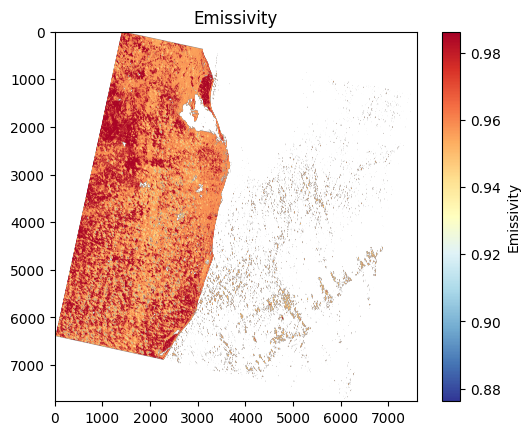

In [ ]:
# Show image
plt.imshow(emissivity, cmap="RdYlBu_r")
plt.colorbar(label="Emissivity")
plt.title("Emissivity")
plt.show()

## Change Projection
```py
def reproject_geotiff(src_path, target_path,target_crs):
    
    with rasterio.open(src_path) as src:
        img = src.read().astype(np.float32)
        
        # Set the nodata values to NaN
        img[img == src.nodata] = np.nan
        
        # Define target CRS (e.g., WGS84)
        target_crs = rasterio.crs.CRS.from_epsg(target_crs)

        # Calculate the default transform for the reprojected image
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        # Create an array to hold the reprojected image
        reprojected_img = np.zeros((img.shape[0], height, width), dtype=img.dtype)
        
        # Reproject the image to match the transformed bounds
        reproject(
            src.read(),
            reprojected_img,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
        )
        
        # Update the metadata for the reprojected image
        reprojected_meta = src.meta.copy()
        reprojected_meta.update(
            {
                "crs": target_crs,
                "transform": transform,
                "width": width,
                "height": height,
            }
        )

        # Set the nodata values to NaN
        reprojected_img[reprojected_img == src.nodata] = np.nan

        # Write the reprojected image to a new GeoTIFF file
        with rasterio.open(target_path, "w", **reprojected_meta) as dst:
            dst.write(reprojected_img)

        return dst, reprojected_img
```



In [ ]:
reprojected_ndvi, reprojected_ndvi_array = utils.reproject_geotiff(
    file_ndvi, file_ndvi_repr, 4326
)
reprojected_img, reprojected_img_array = utils.reproject_geotiff(
    file_lst, file_lst_repr, 4326
)
reprojected_emissivity, reprojected_emissivity_array = utils.reproject_geotiff(
    file_emissivity, file_emissivity_repr, 4326
)

Text(0.5, 1.0, 'Land surface temperature (°C)')

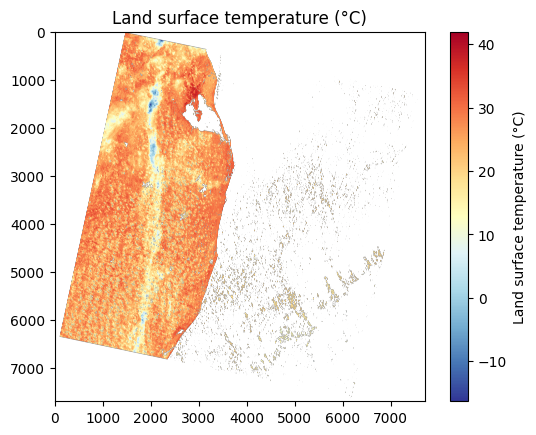

In [ ]:
# Show reprojected landsat image for LST
with rasterio.open(file_lst_repr) as src:
    temperature_reprojected = src.read(1)

plt.imshow(temperature_reprojected, cmap="RdYlBu_r")
plt.colorbar(label="Land surface temperature (°C)")
plt.title("Land surface temperature (°C)")

## Change Colors
```py
def create_rgba_color_image(src_path: Path, target_path: Path, colormap="RdBu_r"):
    
    '''
    Function to map raster values to rgba.

    Parameters
    ----------
    src_path : Path
        Path to the source raster file. Assumes that the raster has a single band.
    target_path : Path
        Path to the target raster file. Raster will have 4 bands.
    '''
    
    with rasterio.open(str(src_path)) as src:
        band = src.read(1)
        bounds = src.bounds
        meta = src.meta.copy()

    # Normalize band values to range [0, 1]
    band_norm = (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))

    # Get minimum and maximum, ignoring NaNs
    vmin = np.nanmin(band_norm)
    vmax = np.nanmax(band_norm)

    # For values less than vmin, assign 0
    band_norm[band_norm < vmin] = 0

    # Linear stretch normalization to range [0, 1]
    band_norm = (band_norm - vmin) / (vmax - vmin)

    # Create a colormap
    cmap = plt.get_cmap(colormap)
    norm = colors.Normalize(vmin=0, vmax=1)

    # Apply the colormap to the normalized band values
    image = cmap(norm(band_norm))

    # Convert the float values in [0,1] to uint8 values in [0,255]
    image = (image * 255).astype(np.uint8)

    # Create paths for the PNG and JSON files
    png_image_path = target_path.parent / (target_path.stem + ".png")
    json_path = target_path.parent / (target_path.stem + "_bounds.json")

    # Save the image as a PNG
    plt.imsave(png_image_path, image)

    # Save the bounds in a JSON file
    bbox = [
        [bounds.bottom, bounds.left],
        [bounds.top, bounds.right],
    ]
    with open(json_path, "w", encoding="utf-8") as file:
        json.dump(bbox, file)

    # Update metadata
    meta.update(count=4, dtype=rasterio.uint8)

    # Write the reprojected image to a new GeoTIFF file
    with rasterio.open(target_path, "w", **meta) as dst:
        # Move channel information to first axis
        img_rio = np.moveaxis(image, source=2, destination=0)
        dst.write(img_rio.astype(rasterio.uint8))

    return dst, image

```


In [ ]:
colored_img_ndvi, colored_img_ndvi_array = utils.create_rgba_color_image(
    reprojected_ndvi.name, file_ndvi_repr_colored
)
colored_img, colored_img_array = utils.create_rgba_color_image(
    reprojected_img.name, file_lst_repr_colored
)
colored_img_emissivity, colored_img_emissivity_array = utils.create_rgba_color_image(
    reprojected_emissivity.name, file_emissivity_repr_colored
)

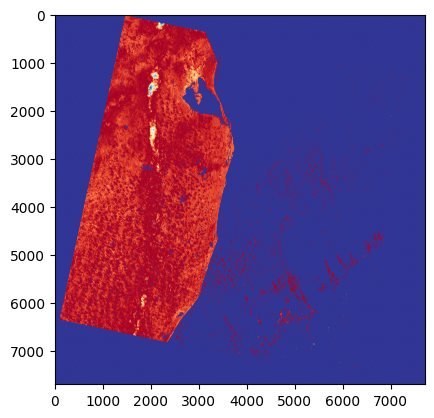

In [ ]:
with rasterio.open(file_lst_repr_colored) as src:
    temperature_reprojected_colored = src.read(1)

plt.imshow(temperature_reprojected_colored, cmap="RdYlBu_r");

## Plot Folium Temperature Map

In [ ]:
with rasterio.open(file_ndvi_repr_colored) as colored_ndvi:
    # Load GeoTIFF as ndarray
    colored_ndvi_array = colored_ndvi.read()

    # Move channel axis to third position
    colored_ndvi_array = np.moveaxis(colored_ndvi_array, source=0, destination=2)

In [ ]:
with rasterio.open(file_lst_repr_colored) as colored_img:
    # Load GeoTIFF as ndarray
    colored_img_array = colored_img.read()

    # Move channel axis to third position
    colored_img_array = np.moveaxis(colored_img_array, source=0, destination=2)

In [ ]:
with rasterio.open(file_emissivity_repr_colored) as colored_emissivity:
    # Load GeoTIFF as ndarray
    colored_emissivity_array = colored_emissivity.read()

    # Move channel axis to third position
    colored_emissivity_array = np.moveaxis(colored_emissivity_array, source=0, destination=2)

In [ ]:
"""folium_map = folium.Map(
    location=[
        (colored_img.bounds.bottom + colored_img.bounds.top) / 2,
        (colored_img.bounds.left + colored_img.bounds.right) / 2,
    ],
    tiles="Stamen Terrain",
    attr="Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors",
    zoom_start=11,
)"""

folium_map = folium.Map(
    location=[
        (colored_img.bounds.bottom + colored_img.bounds.top) / 2,
        (colored_img.bounds.left + colored_img.bounds.right) / 2,
    ],
    tiles="OpenStreetMap",
    zoom_start=11,
)

# Add Emissivity layer
folium.raster_layers.ImageOverlay(
    image=colored_emissivity_array,
    name="Emissivity",
    opacity=0.75,
    bounds=[
        [colored_emissivity.bounds.bottom, colored_emissivity.bounds.left],
        [colored_emissivity.bounds.top, colored_emissivity.bounds.right],
    ],
).add_to(folium_map)

# Add NDVI layer
folium.raster_layers.ImageOverlay(
    image=colored_ndvi_array,
    name="Normalized Difference Vegetation Index (NDVI)",
    opacity=0.75,
    bounds=[
        [colored_ndvi.bounds.bottom, colored_ndvi.bounds.left],
        [colored_ndvi.bounds.top, colored_ndvi.bounds.right],
    ],
).add_to(folium_map)

# Add Land Surface Temperature layer
folium.raster_layers.ImageOverlay(
    image=colored_img_array,
    name="Land Surface Temperature",
    opacity=0.75,
    bounds=[
        [colored_img.bounds.bottom, colored_img.bounds.left],
        [colored_img.bounds.top, colored_img.bounds.right],
    ],
).add_to(folium_map)

folium.LayerControl().add_to(folium_map)

folium_map